In [30]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pydicom as dicom
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import LabelEncoder

In [6]:
def showImage(image, name=None):
    plt.imshow(image, cmap='gray')
    plt.title(name)
    plt.axis('off')
    plt.show()

def erosion(image):
    kernel = np.ones((5,5), np.uint8)
    erosion = cv2.erode(image, kernel, iterations = 1)
    return erosion

def dilation(image):
    kernel = np.ones((5,5), np.uint8)
    dilation = cv2.dilate(image, kernel, iterations = 1)
    return dilation

def opening(image):
    kernel = np.ones((5,5), np.uint8)
    opening = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
    return opening

def closing(image):
    kernel = np.ones((5,5), np.uint8)
    closing = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    return closing

def topHat(image):
    kernel = np.ones((5,5), np.uint8)
    tophat = cv2.morphologyEx(image, cv2.MORPH_TOPHAT, kernel)
    return tophat

def blackHat(image):
    kernel = np.ones((5,5), np.uint8)
    blackhat = cv2.morphologyEx(image, cv2.MORPH_BLACKHAT, kernel)
    return blackhat

def change_brightness(image, alpha, beta):
    result = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return result

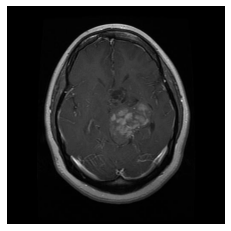

In [7]:
img = cv2.imread('Training/glioma_tumor/gg (1).jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
showImage(img)

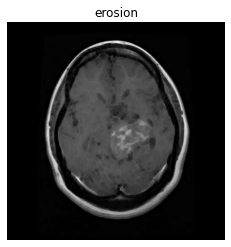

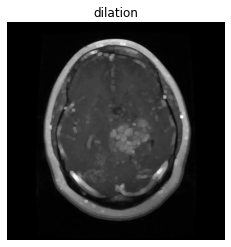

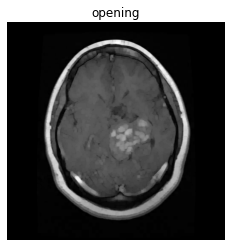

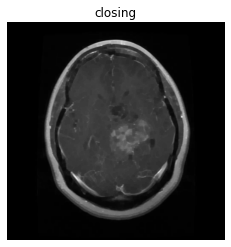

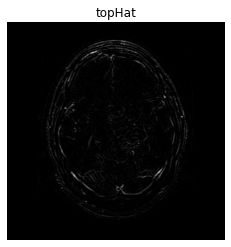

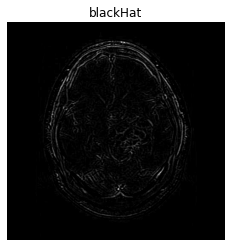

In [8]:
morphological_operations = ["erosion", "dilation", "opening", "closing", "topHat", "blackHat"]

for operation_name in morphological_operations:
    operation_function = globals()[operation_name]
    result = operation_function(img)
    showImage(result, operation_name)

Operacje, które według mnie mogą wypływać pozytywnie na odnalezienie obszaru zarażonego to:
- erozja
- dylatacja
- otwarcie
- zamknięcie

Następnie sądzę, że warto spróbować zmienić jasność oraz operację bluru, aby sprawdzić, jak one wpłyną na wyróżnienie obszaru poszukiwanego.

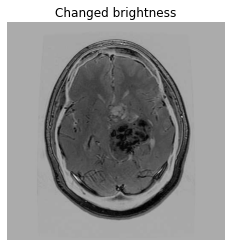

In [9]:
# :param alpha: Współczynnik skalowania (zmiana kontrastu).
# :param beta: Przesunięcie jasności.
img_bright = change_brightness(img, alpha=1, beta=-100)
showImage(img_bright, "Changed brightness")

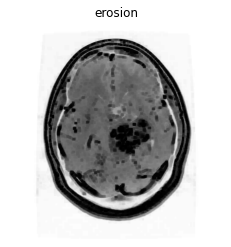

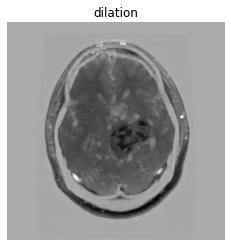

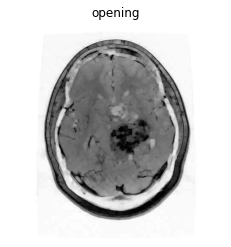

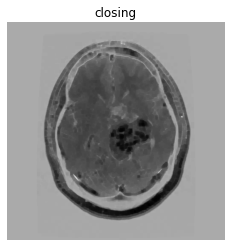

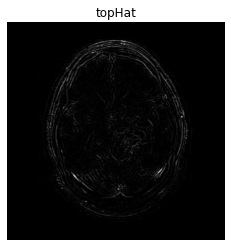

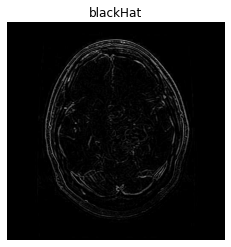

In [10]:
for operation_name in morphological_operations:
    operation_function = globals()[operation_name]
    result = operation_function(img_bright)
    showImage(result, operation_name)

Teraz operacje erozji oraz otwarcia zdecydowanie posiadają lepszy rezultat. Sprawdzałem również jak działa połączenie erozji z innymi operacjami, lecz nie dawało to satysfakconujących wyników.

# Tworzenie masek

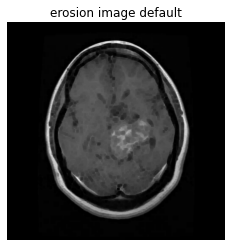

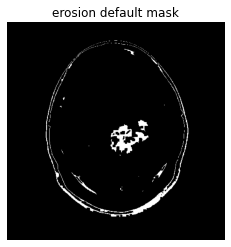

In [11]:
erosion_first = erosion(img)
showImage(erosion_first, "erosion image default")
showImage(np.where((erosion_first > 65) & (erosion_first < 100), 1, 0), "erosion default mask")

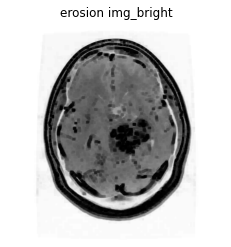

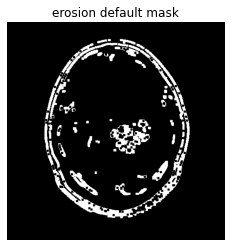

In [12]:
erosion_second = erosion(img_bright)
showImage(erosion_second, "erosion img_bright")
showImage(np.where((erosion_second > 0) & (erosion_second < 15), 1, 0), "erosion default mask")

Poprawną maskę jest trudno stworzyć, ponieważ wiele wartości dookoło posiada również podobną skalę szarości.

# Stworzenie prostego modelu uczenia, aby sprawdzić czy zdjęcia po użyciu operacji morfologicznych dobrze wpływają na wyniki

In [23]:
def load_images_from_folder(folder):
    images = []
    labels = []
    class_names = os.listdir(folder)
    
    for class_name in class_names:
        class_path = os.path.join(folder, class_name)
        
        if os.path.isdir(class_path):
            for filename in os.listdir(class_path):
                if filename.endswith(('.jpg', '.jpeg', '.png')):
                    image_path = os.path.join(class_path, filename)
                    image = cv2.imread(image_path)
                    image = cv2.resize(image, (224,224))
                    images.append(image)
                    labels.append(class_name)
    
    return np.array(images), np.array(labels)

train_folder = 'Training'
test_folder = 'Testing'
train_images, train_labels = load_images_from_folder(train_folder)
test_images, test_labels = load_images_from_folder(test_folder)

In [34]:
train_data = list(zip(train_images, train_labels))
np.random.shuffle(train_data)
shuffled_train_images, shuffled_train_labels = zip(*train_data)
shuffled_train_images = np.array(shuffled_train_images)
shuffled_train_labels = np.array(shuffled_train_labels)
label_encoder = LabelEncoder()
encoded_train_labels = label_encoder.fit_transform(shuffled_train_labels)
encoded_test_labels = label_encoder.transform(test_labels)

In [36]:
tf.random.set_seed(42)
input_shape = (224, 224, 3)
num_classes = len(os.listdir(train_folder))
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(10, 3, activation="relu", input_shape=input_shape))
model.add(tf.keras.layers.Conv2D(10, 3, activation="relu"))
model.add(tf.keras.layers.MaxPool2D())
model.add(tf.keras.layers.Conv2D(10, 3, activation="relu"))
model.add(tf.keras.layers.Conv2D(10, 3, activation="relu"))
model.add(tf.keras.layers.MaxPool2D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(num_classes, activation="softmax"))

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

history = model.fit(shuffled_train_images, encoded_train_labels, epochs=10, validation_data=(test_images, encoded_test_labels))

Epoch 1/10
90/90 [==============================] - 32s 348ms/step - loss: 3.0682 - accuracy: 0.5749 - val_loss: 2.4473 - val_accuracy: 0.4543
Epoch 2/10
90/90 [==============================] - 32s 353ms/step - loss: 0.4746 - accuracy: 0.8247 - val_loss: 2.4051 - val_accuracy: 0.6015
Epoch 3/10
90/90 [==============================] - 32s 353ms/step - loss: 0.2124 - accuracy: 0.9282 - val_loss: 2.7671 - val_accuracy: 0.6929
Epoch 4/10
90/90 [==============================] - 32s 357ms/step - loss: 0.0963 - accuracy: 0.9704 - val_loss: 3.6068 - val_accuracy: 0.7183
Epoch 5/10
90/90 [==============================] - 32s 359ms/step - loss: 0.0471 - accuracy: 0.9902 - val_loss: 3.8061 - val_accuracy: 0.7132
Epoch 6/10
90/90 [==============================] - 32s 359ms/step - loss: 0.0435 - accuracy: 0.9895 - val_loss: 4.4567 - val_accuracy: 0.6802
Epoch 7/10
90/90 [==============================] - 33s 367ms/step - loss: 0.0315 - accuracy: 0.9937 - val_loss: 4.8452 - val_accuracy: 0.6904

### Powtórzenie operacji na zdjęciach po użyciu operacji erozji.

In [37]:
def load_images_from_folder(folder):
    images = []
    labels = []
    class_names = os.listdir(folder)
    
    for class_name in class_names:
        class_path = os.path.join(folder, class_name)
        
        if os.path.isdir(class_path):
            for filename in os.listdir(class_path):
                if filename.endswith(('.jpg', '.jpeg', '.png')):
                    image_path = os.path.join(class_path, filename)
                    image = cv2.imread(image_path)
                    image = cv2.resize(image, (224,224))
                    image = erosion(image)
                    images.append(image)
                    labels.append(class_name)
    
    return np.array(images), np.array(labels)

train_folder = 'Training'
test_folder = 'Testing'
train_images, train_labels = load_images_from_folder(train_folder)
test_images, test_labels = load_images_from_folder(test_folder)

In [38]:
train_data = list(zip(train_images, train_labels))
np.random.shuffle(train_data)
shuffled_train_images, shuffled_train_labels = zip(*train_data)
shuffled_train_images = np.array(shuffled_train_images)
shuffled_train_labels = np.array(shuffled_train_labels)
label_encoder = LabelEncoder()
encoded_train_labels = label_encoder.fit_transform(shuffled_train_labels)
encoded_test_labels = label_encoder.transform(test_labels)

In [39]:
tf.random.set_seed(42)
input_shape = (224, 224, 3)
num_classes = len(os.listdir(train_folder))
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(10, 3, activation="relu", input_shape=input_shape))
model.add(tf.keras.layers.Conv2D(10, 3, activation="relu"))
model.add(tf.keras.layers.MaxPool2D())
model.add(tf.keras.layers.Conv2D(10, 3, activation="relu"))
model.add(tf.keras.layers.Conv2D(10, 3, activation="relu"))
model.add(tf.keras.layers.MaxPool2D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(num_classes, activation="softmax"))

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

history = model.fit(shuffled_train_images, encoded_train_labels, epochs=10, validation_data=(test_images, encoded_test_labels))

Epoch 1/10
90/90 [==============================] - 32s 357ms/step - loss: 2.3653 - accuracy: 0.5732 - val_loss: 1.9502 - val_accuracy: 0.5787
Epoch 2/10
90/90 [==============================] - 33s 361ms/step - loss: 0.4205 - accuracy: 0.8432 - val_loss: 1.9482 - val_accuracy: 0.6904
Epoch 3/10
90/90 [==============================] - 31s 349ms/step - loss: 0.1662 - accuracy: 0.9415 - val_loss: 2.9598 - val_accuracy: 0.7234
Epoch 4/10
90/90 [==============================] - 32s 350ms/step - loss: 0.0784 - accuracy: 0.9794 - val_loss: 3.4638 - val_accuracy: 0.7411
Epoch 5/10
90/90 [==============================] - 31s 349ms/step - loss: 0.0340 - accuracy: 0.9941 - val_loss: 3.8153 - val_accuracy: 0.7690
Epoch 6/10
90/90 [==============================] - 32s 360ms/step - loss: 0.0144 - accuracy: 0.9986 - val_loss: 4.0120 - val_accuracy: 0.7487
Epoch 7/10
90/90 [==============================] - 32s 359ms/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 4.4430 - val_accuracy: 0.7538

Można zauważyć, że użycie operacji erozji pozytywnie wpływa na uczenie się naszego modelu na danych MRI. Sam model i wyniki są tylko poglądowe, czy jest sens korzystać z operacji morfologicznych przy uczeniu maszynowym, co zostaje w tym przypadku potwierdzone wyższym o __4%__ wynikiem zbioru testowego accuracy. Sam model posiada bardzo duży overfitting, lecz poprawianie go nie jest celem tych badań.